# MINI PROJECT

**Data Source** https://www.kaggle.com/c/nlp-getting-started/data  
**Github** https://github.com/cliff003/nlp-getting-started

In [1]:
#import important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive

#EDA and preprocessing
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

#modeling
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.optim as optim
import csv
from tqdm import tqdm


________
# 1. Introduction
_____

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -u -q "/content/drive/Shareddrives/Document/Projects/nlp-getting-started.zip" -d "/content/data"

In [4]:
#label file paths
current_dir = os.getcwd()
path_dir = os.path.join(current_dir, 'data/')
train_path = path_dir + 'train.csv'
sample_solution_path = path_dir + 'sample_submission.csv'
test_path = path_dir + 'test.csv'

In [5]:
#import data
sample_solution = pd.read_csv(sample_solution_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Number of training data: {}".format(len(train)))
print("Number of test data: {}".format(len(test)))

Number of training data: 7613
Number of test data: 3263


We have a 2:1 ratio for training and test data.

________
# 2. Exploratory Analysis (EDA)
_____

In [6]:
# Show the first lines of train dataset
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Show the first lines of test dataset
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# Show the sample submission file
sample_solution.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [9]:
# Check the length of text
train['text_length'] = train['text'].apply(lambda x: len(x))
test['text_length'] = test['text'].apply(lambda x: len(x))
print(f'Average Train text length: {train["text_length"].mean()}')
print(f'Average Test text length: {test["text_length"].mean()}')
print(f'Max Train text length: {train["text_length"].max()}')
print(f'Max Test text length: {test["text_length"].max()}')

Average Train text length: 101.03743596479706
Average Test text length: 102.10818265399939
Max Train text length: 157
Max Test text length: 151


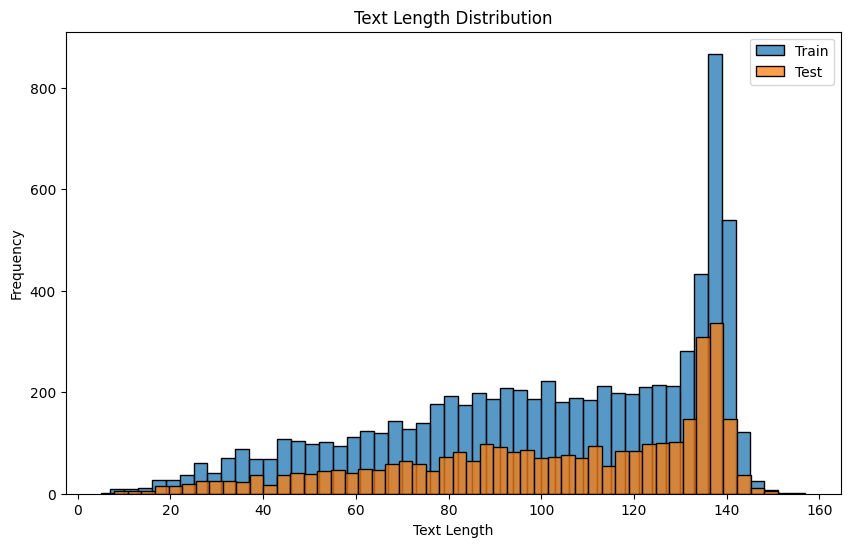

In [10]:
# Show the text length distribution

plt.figure(figsize=(10, 6))
sns.histplot(train['text_length'], bins=50, label='Train')
sns.histplot(test['text_length'], bins=50, label='Test')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


The graph shows that the distribution of test data is similar as train dataset. However, the texts are all came from tweet and the maximum text length for a tweet is 160 character back in the time when the data os collected. Now, the maximum Tweet length grew to 280 characters.

In [11]:
# Check for missing values and duplication
missing_values = train.isnull().sum()
print(missing_values)
duplicated_rows = train.duplicated().sum()
print(f'{duplicated_rows} duplicated rows in labels')

id                0
keyword          61
location       2533
text              0
target            0
text_length       0
dtype: int64
0 duplicated rows in labels


In [12]:
# Calculate the number of targets
category_counts = train['target'].value_counts()
category_counts.head()

target
0    4342
1    3271
Name: count, dtype: int64

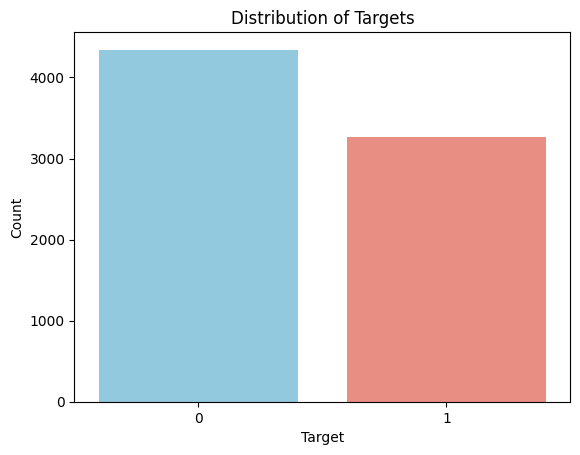

In [13]:
# Plot 0 vs 1
ax = sns.countplot(x='target', hue='target', data=train, palette=['skyblue', 'salmon'], legend=False)
ax.set_title('Distribution of Targets')
ax.set_xlabel('Target')
ax.set_ylabel('Count')
plt.show()

In [14]:
# Download stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Add custom stopwords
additional_stopwords = {'https', 'co', 'amp', 'new', 'u', 'im', 'via'}
stop_words = set(stopwords.words('english')).union(additional_stopwords)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    filtered_tokens = [word for word, tag in tagged_tokens if word not in stop_words and tag != 'VBD']
    text = ' '.join(filtered_tokens)
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [15]:
# Apply clean_text function
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

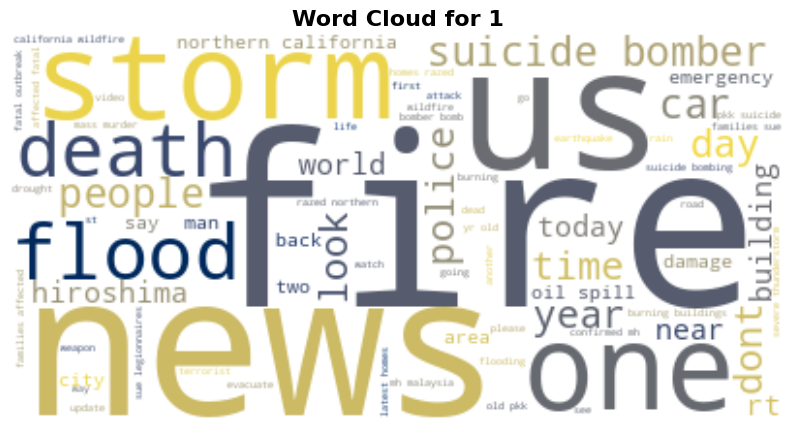

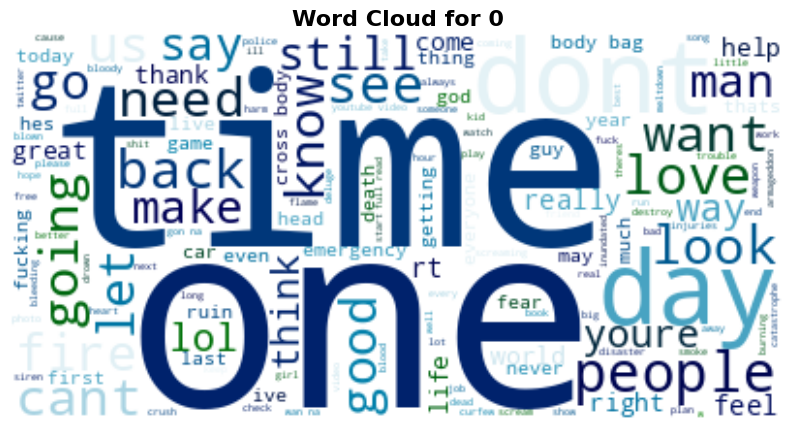

In [16]:
# Set up different color maps for different categories
target_colormaps = {
    0: 'ocean',
    1: 'cividis'
}

# Construct word clouds
for target in train['target'].unique():
    text = " ".join(txt for txt in train[train['target'] == target]['clean_text'])
    wordcloud = WordCloud(background_color="white", colormap=target_colormaps[target]).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {target}", fontsize=16, fontweight='bold')
    plt.show()


From the training set, we could see that there is more 0 than 1. But it is relatively balanced in this dataset.

In [17]:
def transform_text(df, keyword_weight=3, location_weight=3):
    """
    Transforms the input DataFrame by emphasizing 'keyword' and 'location' fields.

    Args:
        df (pd.DataFrame): DataFrame containing 'keyword', 'location', and 'text' columns.
        keyword_weight (int): Number of times to repeat 'keyword' to emphasize it.
        location_weight (int): Number of times to repeat 'location' to emphasize it.

    Returns:
        pd.DataFrame: DataFrame with an added 'input_text' column containing the transformed text.
    """
    df['keyword'] = df['keyword'].fillna('')
    df['location'] = df['location'].fillna('')
    df['input_text'] = (df['keyword'] + ' ') * keyword_weight + (df['location'] + ' ') * location_weight + df['clean_text']
    return df

In [18]:
train = transform_text(train, keyword_weight=3, location_weight=3)
test = transform_text(test, keyword_weight=3, location_weight=3)

In [19]:
train.head(10)

,id,keyword,location,text,target,text_length,clean_text,input_text
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive us,deeds reason earthquake may allah forgiv...
1,4,,,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,,,All residents asked to 'shelter in place' are ...,1,133,residents shelter place notified officers evac...,residents shelter place notified officer...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders cal...,people receive wildfires evacuation orde...
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,88,got photo ruby alaska smoke wildfires pours sc...,got photo ruby alaska smoke wildfires po...
5,8,,,#RockyFire Update => California Hwy. 20 closed...,1,110,rockyfire update california hwy closed directi...,rockyfire update california hwy closed d...
6,10,,,#flood #disaster Heavy rain causes flash flood...,1,95,flood disaster heavy rain causes flash floodin...,flood disaster heavy rain causes flash f...
7,13,,,I'm on top of the hill and I can see a fire in...,1,59,top hill see fire woods,top hill see fire woods
8,14,,,There's an emergency evacuation happening now ...,1,79,theres emergency evacuation happening building...,theres emergency evacuation happening bu...
9,15,,,I'm afraid that the tornado is coming to our a...,1,52,afraid tornado coming area,afraid tornado coming area


-------
# 3. Model Architecture
-----



## 3.1 Bidirectional Encoder Representations from Transformers (BERT)

Bidirectional Encoder Representations from Transformers (BERT) is a state-of-art model used in NLP tasks, designed to handle a wide array of tasks such as text classification, question answering, and more. It is based on the Transformer architecture, which has significantly impacted NLP applications by enabling models to understand the context of words in a sentence more effectively.
The model used here is DistilBERT, introduced by Hugging Face, which is a smaller, faster, and lighter version of BERT that retains 97% of BERT's performance on language understanding benchmarks while being 40% smaller and 60% faster. Due to computational power restrction, this lighter version can be used on CPU only environment for this task.

Here is the architecture of DistilBERT:

<img src=https://raw.githubusercontent.com/cliff003/DTSA5510_mini/b9c68ca2bb65cd48bd8d872f1282317f5aa7921f/images/distilBERT.png width=1000 alt="architecture">  

*Image from Adel, Hadeer & Dahou, Abdelghani & Mabrouk, Alhassan & Elsayed Abd Elaziz, Mohamed & Kayed, Mohammed & El-henawy, Ibrahim & Alshathri, Samah & Ali, Abdelmgeid. (2022). Improving Crisis Events Detection Using DistilBERT with Hunger Games Search Algorithm. Mathematics. 10. 447. 10.3390/math10030447.*

### Below is the pytorch implementation of DistilBERT

In [20]:
class DistilBERTClassifier:

    def __init__(self, model_name='distilbert-base-uncased', num_labels=5, batch_size=4, epochs=5, lr=1e-5, eps=1e-8, max_length=256):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.batch_size = batch_size
        self.epochs = epochs
        self.encoder = LabelEncoder()
        self.lr = lr
        self.eps = eps
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.model.to(self.device)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, eps=self.eps)

        # Placeholder for keeping track of metrics
        self.train_losses = []
        self.val_losses = []
        self.val_f1_scores = []
        self.val_accuracies = []

    def tokenize_data(self, texts, labels=None):
        encoded_batch = self.tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_batch['input_ids']
        attention_masks = encoded_batch['attention_mask']

        if labels is not None:
            labels = torch.tensor(labels).long()
            dataset = TensorDataset(input_ids, attention_masks, labels)
        else:
            dataset = TensorDataset(input_ids, attention_masks)

        return dataset

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc="Training"):
            batch = [b.to(self.device) for b in batch]
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            self.optimizer.zero_grad()

            outputs = self.model(**inputs)
            loss = outputs[0]
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

        avg_loss = total_loss / len(dataloader)
        return avg_loss

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        predictions, true_vals = [], []

        for batch in tqdm(dataloader, desc="Evaluation"):
            batch = [b.to(self.device) for b in batch]
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            loss = outputs[0]
            logits = outputs[1]
            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

        avg_loss = total_loss / len(dataloader)
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        return avg_loss, predictions, true_vals

    def train(self, train_texts, train_labels, val_texts, val_labels):
        train_labels = self.encoder.fit_transform(train_labels)
        val_labels = self.encoder.fit_transform(val_labels)
        train_dataset = self.tokenize_data(train_texts, train_labels)
        val_dataset = self.tokenize_data(val_texts, val_labels)

        train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=self.batch_size)
        val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=self.batch_size//2)

        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * self.epochs)

        for epoch in range(self.epochs):
            print(f'\nEpoch {epoch + 1}/{self.epochs}')
            print('-' * 10)

            train_loss = self.train_epoch(train_dataloader)
            self.train_losses.append(train_loss)

            val_loss, predictions, true_vals = self.evaluate(val_dataloader)
            self.val_losses.append(val_loss)

            preds_flat = np.argmax(predictions, axis=1).flatten()
            labels_flat = true_vals.flatten()
            val_accuracy = accuracy_score(labels_flat, preds_flat)
            self.val_accuracies.append(val_accuracy)

            val_f1 = f1_score(np.argmax(predictions, axis=1), true_vals, average='weighted')
            self.val_f1_scores.append(val_f1)

            torch.save(self.model.state_dict(), f'DistilBERT_epoch{epoch+1}.model')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            print(f'F1 Score (Weighted): {val_f1}')

    def save_log(self, filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Validation F1 Score', 'Validation Accuracy'])
            for epoch in range(self.epochs):
                writer.writerow([
                    epoch+1,
                    self.train_losses[epoch],
                    self.val_losses[epoch],
                    self.val_f1_scores[epoch],
                    self.val_accuracies[epoch]
            ])

    def plot_metrics(self, filename):
        # Read the training log
        df_log = pd.read_csv(filename)

        # Extract metrics
        epochs = df_log['Epoch']
        train_losses = df_log['Training Loss']
        val_losses = df_log['Validation Loss']
        val_f1_scores = df_log['Validation F1 Score']

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.plot(epochs, val_f1_scores, label='Validation F1 Score', linestyle='--')

        plt.title('Training and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, texts, model_path=None):
        dataset = self.tokenize_data(texts)
        dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=1)

        if model_path is not None:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))

        self.model.eval()
        predictions = []

        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1]
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            predictions.append(logits)

        predictions = np.concatenate(predictions, axis=0)

        predicted_labels = (predictions[:, 1] >= 0.5).astype(int)

        return predicted_labels


In [21]:
num_labels = len(category_counts)
DistilBERT = DistilBERTClassifier(num_labels=num_labels, batch_size=64, epochs=20, lr=1e-6)
DistilBERT.model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Here is the overview of DistilBert Model.

In [22]:
text = train['text'].values

# Split train and validation
X_train, X_val, y_train, y_val = train_test_split(text, train['target'], test_size=0.2, random_state=0)

# Train the model
log_path = '/content/drive/Shareddrives/Document/Projects/nlp/training_log.csv'
DistilBERT.train(X_train, y_train, X_val, y_val)
DistilBERT.save_log(log_path)


Epoch 1/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.18it/s]


Training Loss: 0.6768
Validation Loss: 0.6523, Validation Accuracy: 0.7636
F1 Score (Weighted): 0.7745885308089879

Epoch 2/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.14it/s]


Training Loss: 0.6197
Validation Loss: 0.5637, Validation Accuracy: 0.7820
F1 Score (Weighted): 0.7837534871780055

Epoch 3/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.19it/s]


Training Loss: 0.5270
Validation Loss: 0.4853, Validation Accuracy: 0.8070
F1 Score (Weighted): 0.8105251616517467

Epoch 4/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.17it/s]


Training Loss: 0.4625
Validation Loss: 0.4435, Validation Accuracy: 0.8155
F1 Score (Weighted): 0.8167618808318085

Epoch 5/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.16it/s]


Training Loss: 0.4307
Validation Loss: 0.4234, Validation Accuracy: 0.8240
F1 Score (Weighted): 0.8251557869946493

Epoch 6/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.18it/s]


Training Loss: 0.4122
Validation Loss: 0.4125, Validation Accuracy: 0.8280
F1 Score (Weighted): 0.829234615255882

Epoch 7/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.13it/s]


Training Loss: 0.3932
Validation Loss: 0.4053, Validation Accuracy: 0.8319
F1 Score (Weighted): 0.8329846323530978

Epoch 8/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.13it/s]


Training Loss: 0.3852
Validation Loss: 0.3993, Validation Accuracy: 0.8372
F1 Score (Weighted): 0.8383069652169287

Epoch 9/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.14it/s]


Training Loss: 0.3789
Validation Loss: 0.3947, Validation Accuracy: 0.8378
F1 Score (Weighted): 0.8396594840098399

Epoch 10/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.12it/s]


Training Loss: 0.3653
Validation Loss: 0.3964, Validation Accuracy: 0.8411
F1 Score (Weighted): 0.8416093968615209

Epoch 11/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.09it/s]


Training Loss: 0.3632
Validation Loss: 0.3927, Validation Accuracy: 0.8398
F1 Score (Weighted): 0.8406660499714018

Epoch 12/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.13it/s]


Training Loss: 0.3566
Validation Loss: 0.3901, Validation Accuracy: 0.8431
F1 Score (Weighted): 0.8446809910228508

Epoch 13/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.20it/s]


Training Loss: 0.3509
Validation Loss: 0.3897, Validation Accuracy: 0.8431
F1 Score (Weighted): 0.8443547292096812

Epoch 14/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.16it/s]


Training Loss: 0.3437
Validation Loss: 0.3893, Validation Accuracy: 0.8444
F1 Score (Weighted): 0.8455038508080899

Epoch 15/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.20it/s]


Training Loss: 0.3386
Validation Loss: 0.3889, Validation Accuracy: 0.8464
F1 Score (Weighted): 0.8478483925685455

Epoch 16/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.13it/s]


Training Loss: 0.3348
Validation Loss: 0.3937, Validation Accuracy: 0.8398
F1 Score (Weighted): 0.8404328545027298

Epoch 17/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.16it/s]


Training Loss: 0.3310
Validation Loss: 0.3923, Validation Accuracy: 0.8411
F1 Score (Weighted): 0.842068921293031

Epoch 18/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.19it/s]


Training Loss: 0.3221
Validation Loss: 0.3910, Validation Accuracy: 0.8424
F1 Score (Weighted): 0.8438918318021599

Epoch 19/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.20it/s]


Training Loss: 0.3205
Validation Loss: 0.3911, Validation Accuracy: 0.8457
F1 Score (Weighted): 0.8473923993558591

Epoch 20/20
----------


Evaluation: 100%|██████████| 48/48 [00:02<00:00, 19.16it/s]


Training Loss: 0.3163
Validation Loss: 0.3932, Validation Accuracy: 0.8418
F1 Score (Weighted): 0.8430522583244066


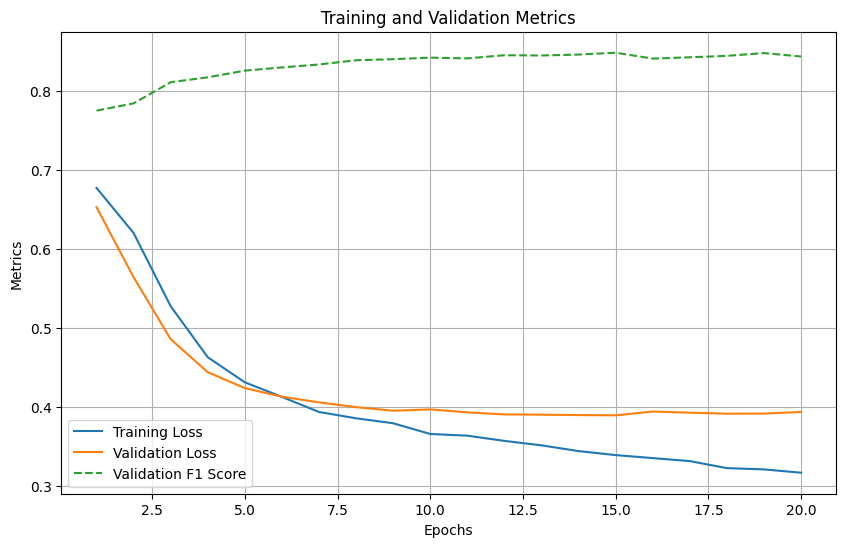

In [23]:
# Plot Metrics vs Epochs
DistilBERT.plot_metrics(log_path)

In [24]:
# Predict on new data
predictions = DistilBERT.predict(list(test['text']))
print(predictions)

[1 1 1 ... 1 1 1]


In [25]:
# Prepare dataframe for submission
BERT_submission = pd.DataFrame(columns=['id', 'target'])
BERT_submission['id'] = test['id']
BERT_submission['target'] = predictions

print(BERT_submission.head())
BERT_submission.to_csv('/content/drive/Shareddrives/Document/Projects/nlp/BERT_submission.csv', index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


In [26]:
# Find the best epoch
log = pd.read_csv(log_path)
min_val_loss = log['Validation Loss'].min()
a = log.loc[pd.read_csv(log_path)['Validation Loss'] == min_val_loss]
print(a)
print(f'Minimum validation loss: {min_val_loss}')

    Epoch  Training Loss  Validation Loss  Validation F1 Score  \
14     15       0.338595         0.388927             0.847848   

    Validation Accuracy  
14             0.846356  
Minimum validation loss: 0.3889274699613452


In [39]:
# Submit the best epoch
predictions = DistilBERT.predict(list(test['text']), model_path='DistilBERT_epoch15.model')
print(predictions)
BERT_submission = pd.DataFrame(columns=['id', 'target'])
BERT_submission['id'] = test['id']
BERT_submission['target'] = predictions

print(BERT_submission.head())
BERT_submission.to_csv('/content/drive/Shareddrives/Document/Projects/nlp/BERT_submission_15.csv', index=False)

[1 1 1 ... 1 1 1]
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


## 3.2 RNN

The Recurrent Neural Network (RNN) is a type of neural network architecture designed for sequential data, introduced by Elman in 1990. RNNs are particularly well-suited for tasks where the order of the data matters, making them effective for natural language processing (NLP) tasks such as text classification, language modeling, and translation.

## Key Features of RNN:

### Sequential Processing
RNNs are designed to handle sequences of data, maintaining a hidden state that is updated at each time step. This allows the network to retain information about previous inputs in the sequence, making it ideal for tasks involving temporal dependencies.

### Recurrent Connections
- **Hidden State Propagation**: At each time step, the hidden state is updated based on the current input and the previous hidden state. This recurrent connection allows RNNs to capture patterns and dependencies across the entire sequence.
- **Shared Weights**: The same weights are applied at each time step, reducing the number of parameters and enabling the network to generalize across different parts of the sequence.

### Long Short-Term Memory (LSTM) Cells
In the RNN implementation, I use Long Short-Term Memory (LSTM) cells, a type of RNN cell. LSTMs address the vanishing gradient problem that affects standard RNNs, making them capable of learning long-term dependencies.
- **Cell State and Gates**: LSTMs maintain a cell state that runs through the entire sequence, along with gates (input, forget, and output gates) that control the flow of information. This architecture allows LSTMs to retain relevant information over long sequences while discarding irrelevant data.

### Performance
- **Flexibility**: RNNs, particularly LSTMs, are highly effective in modeling temporal dependencies, making them versatile for various sequence-based tasks.
- **Text Classification**: In tasks like text classification, LSTMs can capture the contextual relationships between words, improving the accuracy of the model.

### Architecture
Here is the architecture of my RNN Classifier:

1. **Embedding Layer**: Converts word indices to dense vectors.
2. **LSTM Layer**: Captures temporal dependencies in the input sequences.
3. **Dropout Layer**: Reduces overfitting by dropping random units during training.
4. **Fully Connected Layer**: Produces the final classification output.

### Applications
RNNs, especially LSTMs, are widely used in various domains, including:
- **Text Classification**: Effective in categorizing text data into predefined categories.
- **Language Modeling**: Predicting the next word in a sequence, which is useful for tasks like text generation.
- **Sequence Labeling**: Tasks such as named entity recognition and part-of-speech tagging.
- **Machine Translation**: Translating text from one language to another.

RNNs, and particularly LSTMs, have become essential models in the deep learning community for handling sequential data. Their ability to capture and utilize temporal dependencies makes them invaluable for a wide range of applications in NLP and beyond. In this project, the RNN classifier serves as a powerful tool for text classification tasks, demonstrating its effectiveness and versatility.

In [28]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = clean_text(self.texts[idx])
        inputs = self.tokenizer(text, padding='max_length', max_length=self.max_length, truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return input_ids, attention_mask, label
        else:
            return input_ids, attention_mask


Here is the RNN structuure below

In [29]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_labels, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        rnn_out, _ = self.rnn(embedded)
        pooled_output = torch.mean(rnn_out, dim=1)
        dropout_output = self.dropout(pooled_output)
        logits = self.fc(dropout_output)
        return logits


In [30]:
class RNNTextClassifier:
    def __init__(self, vocab_size, embed_size=128, hidden_size=256, num_layers=2, num_labels=2, batch_size=4, epochs=5, lr=1e-3, max_length=256):
        self.model = RNNClassifier(vocab_size, embed_size, hidden_size, num_layers, num_labels)
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.encoder = LabelEncoder()
        self.train_losses = []
        self.val_losses = []
        self.val_f1_scores = []
        self.val_accuracies = []

    def tokenize_data(self, texts, labels=None, tokenizer=None):
        if labels is not None:
            labels = self.encoder.fit_transform(labels)
        else:
            labels = None
        dataset = TextDataset(texts, labels, tokenizer, self.max_length)
        return dataset

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc="Training"):
            input_ids, attention_mask, labels = [b.to(self.device) for b in batch]
            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            self.optimizer.step()
        avg_loss = total_loss / len(dataloader)
        return avg_loss

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        predictions, true_vals = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluation"):
                input_ids, attention_mask, labels = [b.to(self.device) for b in batch]
                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                logits = outputs.detach().cpu().numpy()
                label_ids = labels.cpu().numpy()
                predictions.append(logits)
                true_vals.append(label_ids)
        avg_loss = total_loss / len(dataloader)
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        return avg_loss, predictions, true_vals

    def train(self, train_texts, train_labels, val_texts, val_labels, tokenizer):
        train_dataset = self.tokenize_data(train_texts, train_labels, tokenizer)
        val_dataset = self.tokenize_data(val_texts, val_labels, tokenizer)

        train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=self.batch_size)
        val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=self.batch_size//2)

        for epoch in range(self.epochs):
            print(f'\nEpoch {epoch + 1}/{self.epochs}')
            print('-' * 10)
            train_loss = self.train_epoch(train_dataloader)
            self.train_losses.append(train_loss)
            val_loss, predictions, true_vals = self.evaluate(val_dataloader)
            self.val_losses.append(val_loss)
            preds_flat = np.argmax(predictions, axis=1).flatten()
            labels_flat = true_vals.flatten()
            val_accuracy = accuracy_score(labels_flat, preds_flat)
            self.val_accuracies.append(val_accuracy)
            val_f1 = f1_score(labels_flat, preds_flat, average='weighted')
            self.val_f1_scores.append(val_f1)
            torch.save(self.model.state_dict(), f'RNN_epoch{epoch+1}.model')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            print(f'F1 Score (Weighted): {val_f1}')

    def save_log(self, filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Validation F1 Score', 'Validation Accuracy'])
            for epoch in range(self.epochs):
                writer.writerow([
                    epoch+1,
                    self.train_losses[epoch],
                    self.val_losses[epoch],
                    self.val_f1_scores[epoch],
                    self.val_accuracies[epoch]
                ])

    def plot_metrics(self, filename):
        df_log = pd.read_csv(filename)
        epochs = df_log['Epoch']
        train_losses = df_log['Training Loss']
        val_losses = df_log['Validation Loss']
        val_f1_scores = df_log['Validation F1 Score']
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.plot(epochs, val_f1_scores, label='Validation F1 Score', linestyle='--')
        plt.title('Training and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, texts, tokenizer, model_path=None):
        dataset = self.tokenize_data(texts, tokenizer=tokenizer)
        dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=1)
        if model_path is not None:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in dataloader:
                input_ids, attention_mask = [b.to(self.device) for b in batch]
                outputs = self.model(input_ids, attention_mask)
                logits = outputs.detach().cpu().numpy()
                predictions.append(logits)
        predictions = np.concatenate(predictions, axis=0)
        predicted_labels = (predictions[:, 1] >= 0.5).astype(int)
        return predicted_labels


In [31]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text = train['text'].values
X_train, X_val, y_train, y_val = train_test_split(text, train['target'], test_size=0.2, random_state=0)
vocab_size = tokenizer.vocab_size
rnn_classifier = RNNTextClassifier(vocab_size=vocab_size, batch_size=128, epochs=20)
rnn_classifier.model

RNNClassifier(
  (embedding): Embedding(30522, 128)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

As shown in the model layers, I construct 2 LSTM layers inside this neural network.

In [32]:
rnn_classifier.train(X_train, y_train, X_val, y_val, tokenizer)



Epoch 1/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.37it/s]


Training Loss: 0.6870
Validation Loss: 0.6792, Validation Accuracy: 0.5817
F1 Score (Weighted): 0.42791817835666046

Epoch 2/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.36it/s]


Training Loss: 0.7063
Validation Loss: 0.6566, Validation Accuracy: 0.5831
F1 Score (Weighted): 0.4308919147274571

Epoch 3/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.28it/s]


Training Loss: 0.6381
Validation Loss: 0.6461, Validation Accuracy: 0.6776
F1 Score (Weighted): 0.6369682244563861

Epoch 4/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.41it/s]


Training Loss: 0.6446
Validation Loss: 0.6661, Validation Accuracy: 0.7019
F1 Score (Weighted): 0.6934873563817984

Epoch 5/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.26it/s]


Training Loss: 0.5947
Validation Loss: 0.5949, Validation Accuracy: 0.7157
F1 Score (Weighted): 0.7117014454744146

Epoch 6/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Training Loss: 0.5371
Validation Loss: 0.5948, Validation Accuracy: 0.7288
F1 Score (Weighted): 0.7198931692212375

Epoch 7/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.43it/s]


Training Loss: 0.5736
Validation Loss: 0.6014, Validation Accuracy: 0.7065
F1 Score (Weighted): 0.6755993190897044

Epoch 8/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.47it/s]


Training Loss: 0.5179
Validation Loss: 0.5999, Validation Accuracy: 0.7236
F1 Score (Weighted): 0.7036178236294099

Epoch 9/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.49it/s]


Training Loss: 0.4983
Validation Loss: 0.5932, Validation Accuracy: 0.7255
F1 Score (Weighted): 0.7067823326378432

Epoch 10/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.37it/s]


Training Loss: 0.4860
Validation Loss: 0.5834, Validation Accuracy: 0.7301
F1 Score (Weighted): 0.7087366098556396

Epoch 11/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Training Loss: 0.4542
Validation Loss: 0.5892, Validation Accuracy: 0.7426
F1 Score (Weighted): 0.7271056268846366

Epoch 12/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.45it/s]


Training Loss: 0.4446
Validation Loss: 0.5967, Validation Accuracy: 0.7466
F1 Score (Weighted): 0.7370818139915577

Epoch 13/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.42it/s]


Training Loss: 0.4021
Validation Loss: 0.6041, Validation Accuracy: 0.7557
F1 Score (Weighted): 0.7476302553961541

Epoch 14/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


Training Loss: 0.3741
Validation Loss: 0.5949, Validation Accuracy: 0.7702
F1 Score (Weighted): 0.761602681080428

Epoch 15/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.51it/s]


Training Loss: 0.3796
Validation Loss: 0.5871, Validation Accuracy: 0.7630
F1 Score (Weighted): 0.7550244640841105

Epoch 16/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.52it/s]


Training Loss: 0.5642
Validation Loss: 0.6587, Validation Accuracy: 0.6809
F1 Score (Weighted): 0.6270332470370229

Epoch 17/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.56it/s]


Training Loss: 0.5366
Validation Loss: 0.7259, Validation Accuracy: 0.6921
F1 Score (Weighted): 0.6407680704923227

Epoch 18/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.51it/s]


Training Loss: 0.5436
Validation Loss: 0.6274, Validation Accuracy: 0.7374
F1 Score (Weighted): 0.7237067325860076

Epoch 19/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.48it/s]


Training Loss: 0.3639
Validation Loss: 0.5598, Validation Accuracy: 0.7643
F1 Score (Weighted): 0.7605870205637503

Epoch 20/20
----------


Evaluation: 100%|██████████| 24/24 [00:02<00:00,  9.45it/s]


Training Loss: 0.2875
Validation Loss: 0.7952, Validation Accuracy: 0.7597
F1 Score (Weighted): 0.7572651756470229


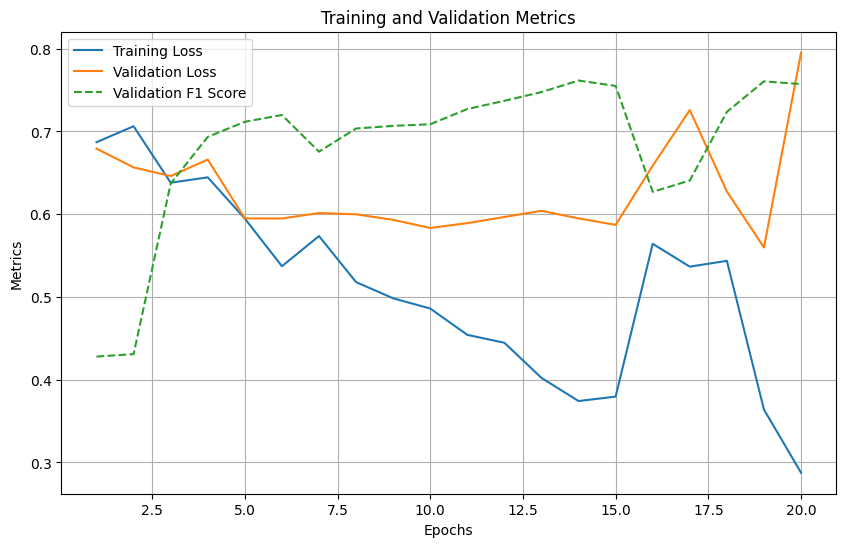

In [33]:
rnn_log_path = '/content/drive/Shareddrives/Document/Projects/nlp/rnn_training_log.csv'
rnn_classifier.save_log(rnn_log_path)
rnn_classifier.plot_metrics(rnn_log_path)

In [34]:
# Predict on new data
predictions = rnn_classifier.predict(list(test['text']), tokenizer=tokenizer)
print(predictions)

[0 0 1 ... 1 1 1]


In [35]:
# Prepare dataframe for submission
RNN_submission = pd.DataFrame(columns=['id', 'target'])
RNN_submission['id'] = test['id']
RNN_submission['target'] = predictions

print(RNN_submission.head())
RNN_submission.to_csv('/content/drive/Shareddrives/Document/Projects/nlp/RNN_submission.csv', index=False)

   id  target
0   0       0
1   2       0
2   3       1
3   9       1
4  11       1


In [42]:
# Find the best epoch
log = pd.read_csv(rnn_log_path)
min_val_loss = log['Validation Loss'].min()
a = log.loc[pd.read_csv(rnn_log_path)['Validation Loss'] == min_val_loss]
print(a)
print(f'Minimum validation loss: {min_val_loss}')

    Epoch  Training Loss  Validation Loss  Validation F1 Score  \
18     19       0.363874         0.559806             0.760587   

    Validation Accuracy  
18             0.764281  
Minimum validation loss: 0.5598062463104725


In [44]:
# Submit the best epoch
predictions = rnn_classifier.predict(list(test['text']), tokenizer=tokenizer, model_path='RNN_epoch19.model')
print(predictions)
RNN_submission = pd.DataFrame(columns=['id', 'target'])
RNN_submission['id'] = test['id']
RNN_submission['target'] = predictions

print(RNN_submission.head())
RNN_submission.to_csv('/content/drive/Shareddrives/Document/Projects/nlp/RNN_submission_19.csv', index=False)

[0 0 1 ... 1 1 1]
   id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       1


______
# 4. Results and Analysis
______



## 4.1 Training Log Analysis

In [36]:
BERT_log_df = pd.read_csv(log_path)
rnn_log_df = pd.read_csv(rnn_log_path)

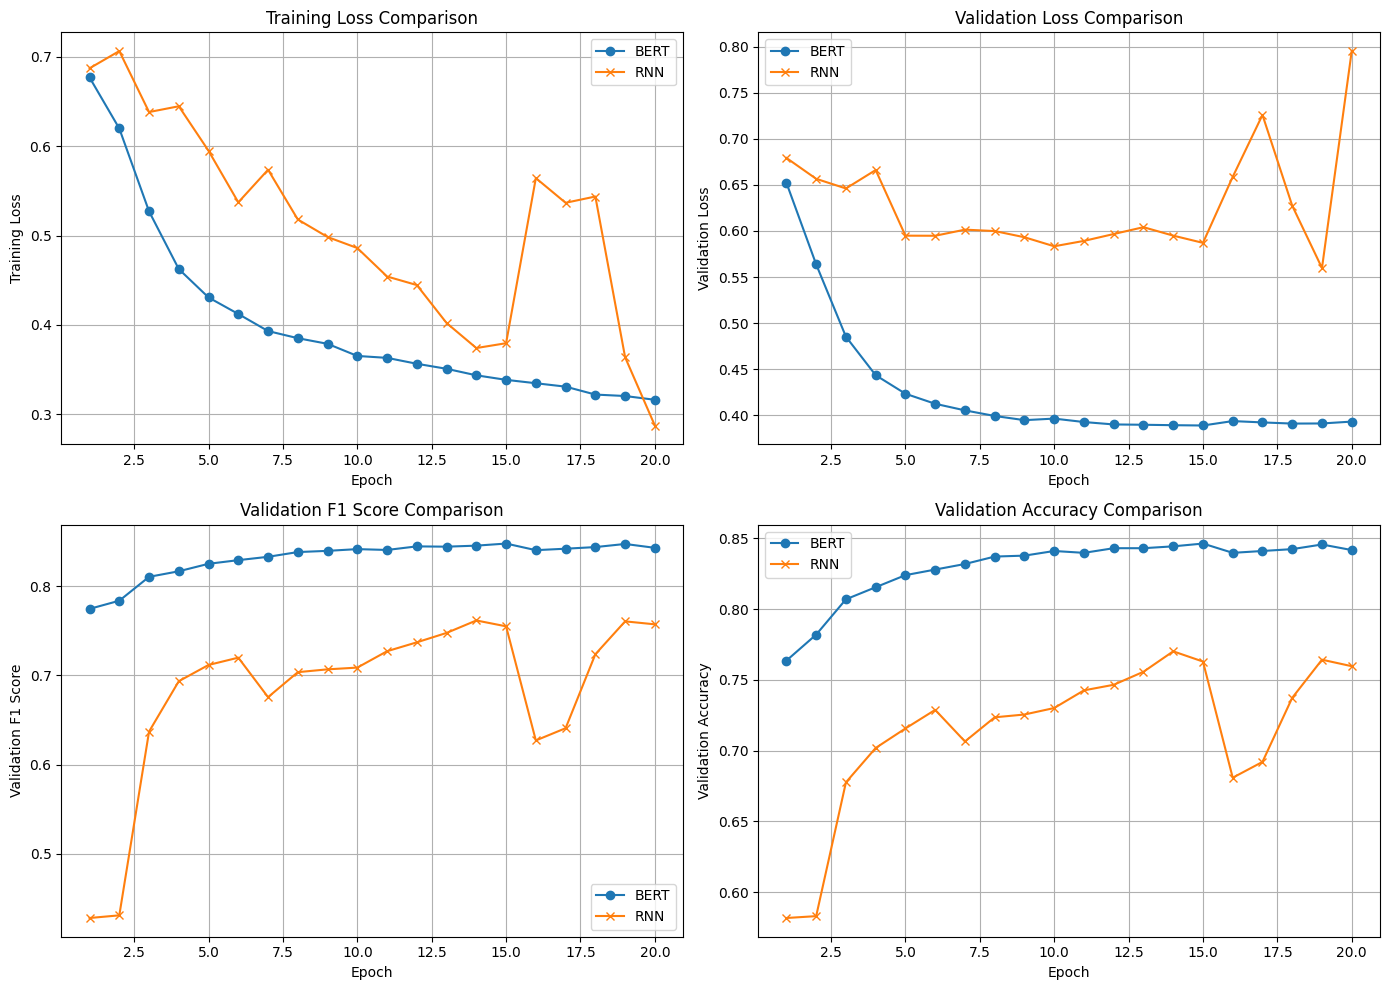

In [37]:
# Create plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].plot(BERT_log_df['Epoch'], BERT_log_df['Training Loss'], label='BERT', marker='o')
ax[0, 0].plot(rnn_log_df['Epoch'], rnn_log_df['Training Loss'], label='RNN', marker='x')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Training Loss')
ax[0, 0].set_title('Training Loss Comparison')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(BERT_log_df['Epoch'], BERT_log_df['Validation Loss'], label='BERT', marker='o')
ax[0, 1].plot(rnn_log_df['Epoch'], rnn_log_df['Validation Loss'], label='RNN', marker='x')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Validation Loss')
ax[0, 1].set_title('Validation Loss Comparison')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(BERT_log_df['Epoch'], BERT_log_df['Validation F1 Score'], label='BERT', marker='o')
ax[1, 0].plot(rnn_log_df['Epoch'], rnn_log_df['Validation F1 Score'], label='RNN', marker='x')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Validation F1 Score')
ax[1, 0].set_title('Validation F1 Score Comparison')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(BERT_log_df['Epoch'], BERT_log_df['Validation Accuracy'], label='BERT', marker='o')
ax[1, 1].plot(rnn_log_df['Epoch'], rnn_log_df['Validation Accuracy'], label='RNN', marker='x')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Validation Accuracy')
ax[1, 1].set_title('Validation Accuracy Comparison')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

We can see that distlBERT converges faster at early epochs, and RNN is not that stable compares with distilBERT.

## 4.2 Kaggle Submission Result

|Models                                  | Score |
|---------------------------------------------------------------|---------------|
| distilBERT 20 epochs | 0.83328       |
| RNN 20 epochs  | 0.74410        |
| distilBERT 15 epochs | 0.83144       |
|  RNN 19 epochs  | 0.74869        |


As we can see in this table, distilBERT perform very well and my score is ranked 205 in the leaderboard. I believe with further hyperparameter tuning, the result will be better.

______
# 5. Conclusions
______



## 5.1 DistilBERT

DistilBERT, a lighter and faster version of the original BERT model, is optimized for speed and efficiency while maintaining minimal loss in accuracy. For text classification tasks, DistilBERT demonstrates superior performance due to its pre-trained knowledge on diverse datasets and its ability to capture contextual information from the input text.

### Key Advantages:
- **Efficiency**: DistilBERT is designed to be more efficient, both in terms of computational resources and training time, making it suitable for large-scale text classification tasks.
- **Pre-trained Weights**: Leveraging extensive pre-training on a wide range of textual data, DistilBERT quickly converges and achieves high accuracy. This pre-training enhances its ability to generalize across different text classification problems.
- **Contextual Understanding**: DistilBERT's architecture allows it to understand the context of words within a sentence, improving its performance on tasks requiring nuanced understanding of text.

### Performance:
- **Early Epochs**: DistilBERT shows significant promise and high accuracy even in the initial epochs, thanks to its pre-trained weights.
- **Higher Epochs**: It continues to improve with more training, maintaining robust performance and stability, which makes it an excellent choice for text classification tasks.

In summary, DistilBERT’s combination of efficiency, pre-trained knowledge, and contextual understanding gives it a distinct advantage in text classification tasks, achieving high accuracy and fast convergence.

## 5.2 RNN

Recurrent Neural Networks (RNNs), particularly those using Long Short-Term Memory (LSTM) cells, are designed to handle sequential data, making them effective for tasks like text classification. However, compared to more modern architectures like DistilBERT, RNNs may require more tuning and longer training times to achieve similar levels of performance.

### Key Characteristics:
- **Sequential Data Handling**: RNNs are inherently suited for processing sequences, capturing temporal dependencies in the input data.
- **LSTM Cells**: By using LSTM cells, RNNs can mitigate issues like the vanishing gradient problem, allowing them to learn long-term dependencies within sequences.
- **Flexibility**: RNNs can be adapted for various sequence-based tasks, although this flexibility sometimes comes at the cost of increased complexity and longer training times.

### Performance:
- **Early Epochs**: RNNs, particularly with LSTM cells, show steady improvement but may not achieve the high accuracy levels seen with pre-trained models like DistilBERT in the initial epochs.
- **Higher Epochs**: With sufficient training, RNNs can achieve competitive performance, though they often require more epochs to converge and might still lag behind in terms of overall accuracy compared to models leveraging extensive pre-training.

In summary, while RNNs, especially those using LSTM cells, are powerful for handling sequential data, they generally require more tuning and longer training times to reach performance levels comparable to pre-trained models like DistilBERT. DistilBERT’s efficiency and robust pre-training give it a significant advantage in text classification tasks, leading to higher accuracy and faster convergence.

## 5.3 Difference between two models



| Feature                          | DistilBERT                                             | RNN (LSTM-based)                                       |
|----------------------------------|--------------------------------------------------------|--------------------------------------------------------|
| **Understanding**                | Designed for natural language understanding with transformers. | Designed for sequential data processing with recurrent connections. |
| **Pre-trained Knowledge**        | Utilizes pre-training on large text datasets (e.g., BooksCorpus, Wikipedia). | Typically requires pre-training on large text datasets or can be trained from scratch. |
| **Task Flexibility**             | Versatile, suitable for a wide range of NLP tasks including classification, NER, Q&A. | Flexible for sequential tasks like text classification, language modeling, and sequence labeling. |
| **Performance on Complex Tasks** | Excels in understanding context and capturing dependencies across long text sequences. | Effective at capturing temporal dependencies and patterns in sequences, especially with long-term dependencies. |
| **Model Complexity**             | Transformer-based, with multiple layers of attention and feed-forward networks. | Composed of LSTM cells with gates and memory cells to handle long-term dependencies. |
| **Resources Required**           | Requires GPUs for efficient training and inference, especially with larger models. | Requires GPUs for efficient training and inference, especially with deeper or more complex RNNs. |
| **Use Cases**                    | Text classification, sentiment analysis, question answering, named entity recognition. | Text classification, sentiment analysis, language modeling, machine translation. |
| **Training Approach**            | Fine-tuning on specific datasets after pre-training; transfer learning is common. | Can be trained from scratch or fine-tuned on specific datasets; may require more epochs compared to transformers. |
| **Learning Paradigm**            | Supervised (requires labeled text data); utilizes transfer learning. | Supervised (requires labeled text data); can be enhanced with transfer learning from pre-trained models. |
| **Handling Long Texts**          | Efficiently handles long-range dependencies due to self-attention mechanism. | May struggle with very long sequences unless using variants like LSTMs or GRUs to manage long-term dependencies. |


# THANK YOU FOR READING!